In [ ]:
#|export
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from n_framework import *
#from learner_module import *

In [ ]:
import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset
from torcheval.metrics import MulticlassAccuracy
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [ ]:
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

In [ ]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train

  0%|          | 0/2 [00:00<?, ?it/s]

## Baseline

In [ ]:
def conv(ni,nf,ks=3,act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [ 
        conv(1,8, ks=5),  #14x14
        conv(8,16),       #7x7
        conv(16,32),      #4x4
        conv(32,64),      #2x2
        conv(64,10,act=False), #1x1
        nn.Flatten()]

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(),DeviceCB(),metrics, ProgressCB(plot=True)]

In [ ]:
def fit(model,epochs=1,xtra_cbs=None):
    learn = Learner(model,dls,loss_func=F.cross_entropy,lr=0.6,cbs=cbs)
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.205,2.233,0,train
0.100,2.302,0,eval


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

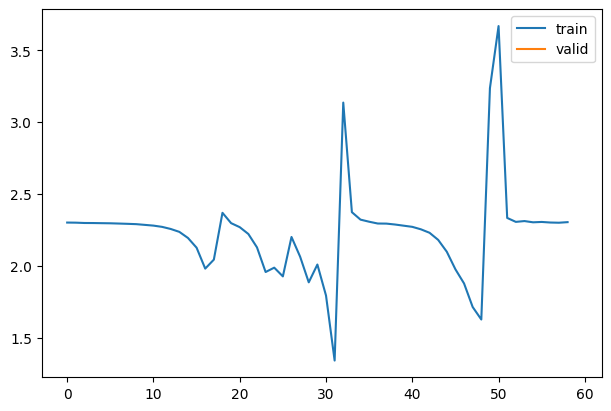

In [ ]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

## Hooks

#### Manual Insertion

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self,*layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_mean = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self,x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_mean[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x
    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.205,2.233,0,train
0.100,2.302,0,eval


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

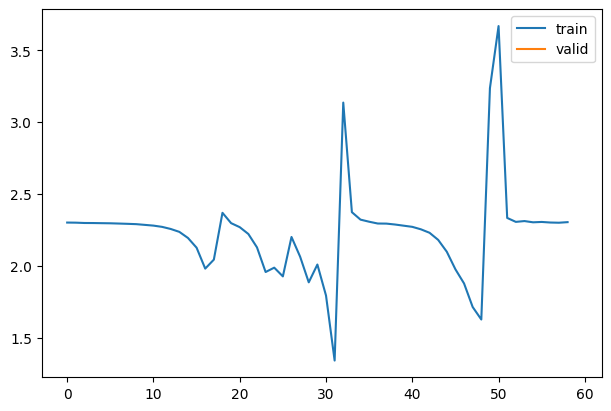

In [ ]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

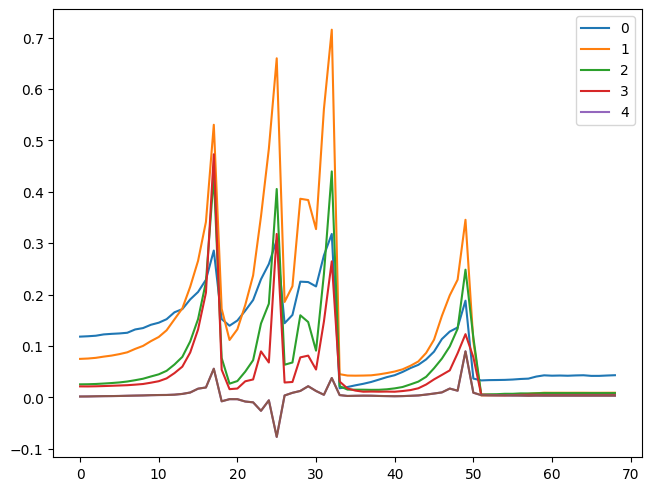

In [ ]:
for l in model.act_mean:plt.plot(l)
plt.legend(range(5));

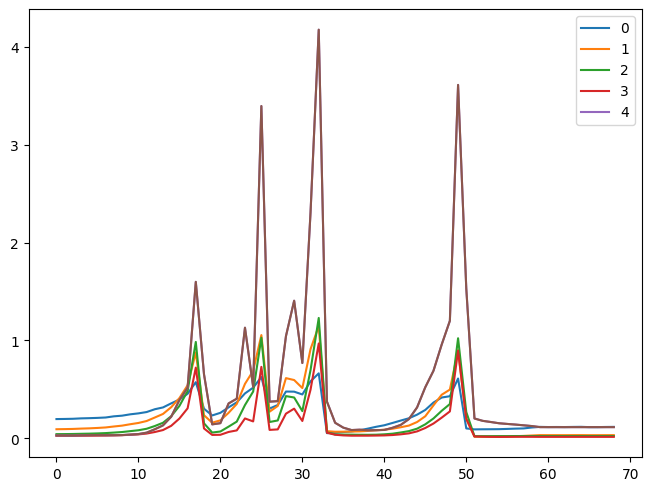

In [ ]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));
     

##### Pytorch Hooks

In [ ]:
set_seed(1)
model = SequentialModel(*cnn_layers())

In [ ]:
act_mean = [[] for _ in model]
act_stds = [[] for _ in model]

In [ ]:
def append_stats(i,mod,inp,outp):
    act_mean[i].append(to_cpu(outp).mean())
    act_stds[i].append(to_cpu(outp).std())

In [ ]:
register_forward_hook?

Object `register_forward_hook` not found.


In [ ]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats,i))

accuracy,loss,epoch,train
0.123,2.345,0,train
0.100,2.303,0,eval


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

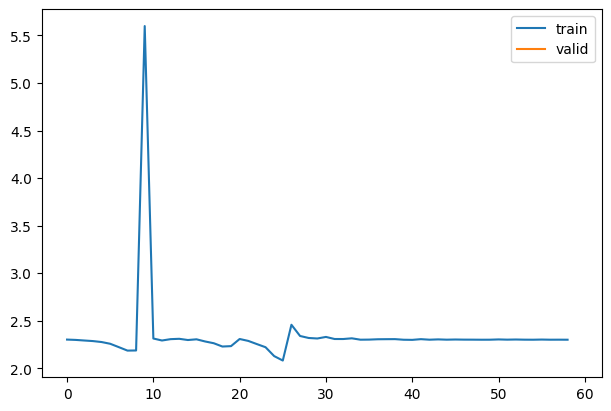

In [ ]:
fit(model);

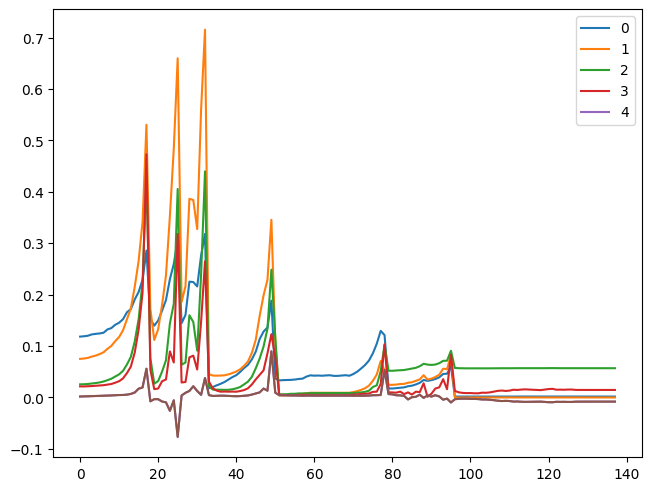

In [ ]:
for o in model.act_mean:plt.plot(o)
plt.legend(range(5));

#### Hook class


In [ ]:
class Hook():
    def __init__(self,m,f): self.hook = m.register_forward_hook(partial(f,self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
        
def append_stats(hook,mod,inp,outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [ ]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.205,2.233,0,train
0.100,2.302,0,eval


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

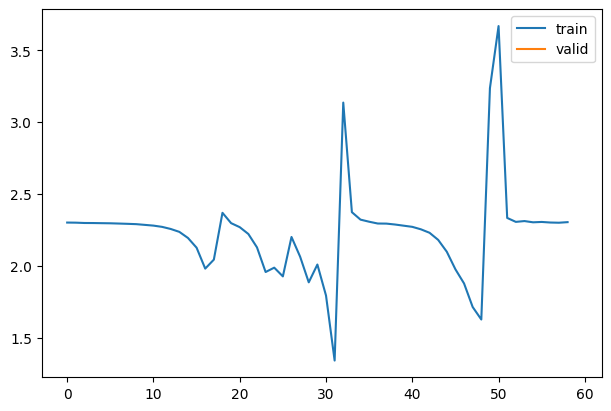

In [ ]:
learn = fit(model)

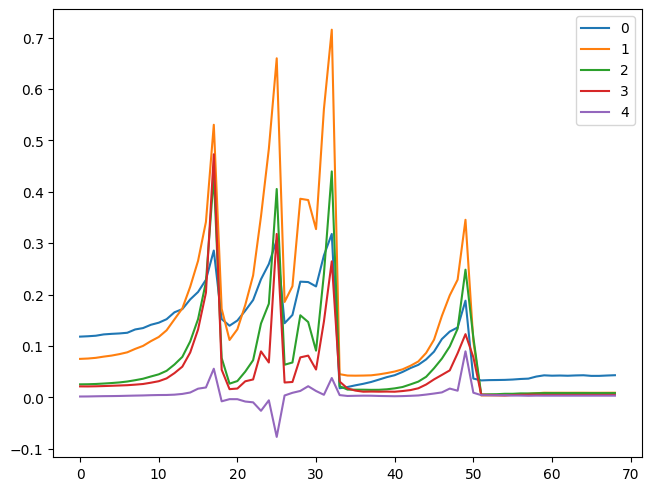

In [ ]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));